In [1]:
import random
from matplotlib import pyplot as plt

In [2]:
class Environment:
    def __init__(self, stochastic=False):
        self.start = (3, 0)
        self.goal = (3, 7)
        self.num_rows = 7
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.num_cols = len(self.wind)
        self.reset()
        self.stochastic = stochastic
    
    def reset(self):
        self.pos = self.start
    
    def take_action(self, action):
        row = self.pos[0]
        col = self.pos[1]
        current_wind = self.wind[col]
        if self.stochastic:
            current_wind = random.choice([current_wind - 1, current_wind, current_wind + 1])
        row += action[0] + current_wind
        row = max(0, min(row, self.num_rows - 1))
        col += action[1]
        col = max(0, min(col, self.num_cols - 1))
        self.pos = (row, col)
        if self.pos == self.goal:
            return 0, self.pos
        else:
            return -1, self.pos
    
    def get_states(self):
        return ((row, col) for row in range(self.num_rows)
                for col in range(self.num_cols))

In [3]:
class TDAgent:
    def __init__(self, states, must_move):
        self.epsilon = 0.1
        self.alpha = 0.5
        if must_move:
            self.actions = [(i, j) for i in [1, 0, -1] for j in [1, 0, -1] if not i == 0 == j]
        else:
            self.actions = [(i, j) for i in [1, 0, -1] for j in [1, 0, -1]]
        self.estimates = {(s, a):0 for s in states for a in self.actions}
    
    def choose_action(self, state, soft=True):
        if soft and random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            return max(self.actions, key=lambda a: self.estimates[(state, a)])
    
    def update(self, s, a, r, s2, a2):
        self.estimates[(s, a)] += self.alpha * (
            r + self.estimates[(s2, a2)] - self.estimates[(s, a)])  

In [4]:
def train(env, agent, time_steps):
    env.reset()
    s = env.start
    a = agent.choose_action(s)
    num_episodes = 0
    res = []
    for t in range(time_steps):
        r, s2 = env.take_action(a)
        a2 = agent.choose_action(s2)
        agent.update(s, a, r, s2, a2)
        if r == 0:
            num_episodes += 1
            env.reset()
            s = env.start
            a = agent.choose_action(s)
        else:
            s = s2
            a = a2
        res.append(num_episodes)
    return res

In [5]:
def get_trajectory(env, agent):
    env.reset()
    s = env.start
    states = [s]
    a = agent.choose_action(s, False)
    r = -1
    while r != 0:
        r, s2 = env.take_action(a)
        a2 = agent.choose_action(s2, False)
        s = s2
        a = a2
        states.append(s)
    grid = [['O' for _ in range(env.num_cols)] for _ in range(env.num_rows)]
    for r, c in states:
        grid[-r - 1][c] = 'X'
    print(states)
    print('\n'.join([''.join(row) for row in grid]))


In [6]:
%%time
env = Environment()
agent = TDAgent(env.get_states(), True)
res = train(env, agent, 8000)
trajectory = get_trajectory(env, agent)

[(3, 0), (3, 1), (2, 2), (1, 2), (1, 3), (2, 4), (2, 5), (2, 6), (3, 7)]
OOOOOOOOOO
OOOOOOOOOO
OOOOOOOOOO
XXOOOOOXOO
OOXOXXXOOO
OOXXOOOOOO
OOOOOOOOOO
CPU times: user 92.8 ms, sys: 110 µs, total: 92.9 ms
Wall time: 91.2 ms


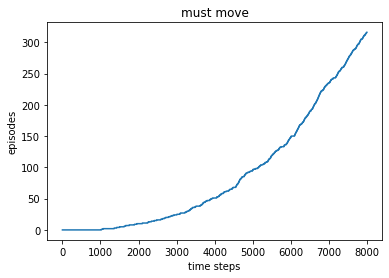

In [7]:
plt.plot(res)
plt.xlabel('time steps')
plt.ylabel('episodes')
plt.title('must move')
plt.savefig('must_move_plot.png')

In [8]:
%%time
env = Environment()
agent = TDAgent(env.get_states(), False)
res = train(env, agent, 8000)
trajectory = get_trajectory(env, agent)

[(3, 0), (4, 0), (3, 1), (2, 2), (1, 2), (0, 3), (0, 4), (0, 5), (2, 5), (2, 6), (3, 7)]
OOOOOOOOOO
OOOOOOOOOO
XOOOOOOOOO
XXOOOOOXOO
OOXOOXXOOO
OOXOOOOOOO
OOOXXXOOOO
CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 38.8 ms


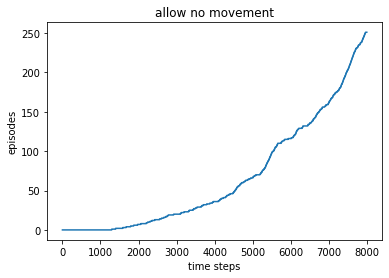

In [9]:
plt.plot(res)
plt.xlabel('time steps')
plt.ylabel('episodes')
plt.title('allow no movement')
plt.savefig('no_movement_plot.png')

In [10]:
%%time
env = Environment(stochastic=True)
agent = TDAgent(env.get_states(), False)
res = train(env, agent, 20000)
trajectory = get_trajectory(env, agent)

[(3, 0), (3, 1), (5, 2), (6, 3), (6, 3), (5, 3), (5, 2), (4, 3), (5, 2), (5, 3), (5, 2), (6, 3), (6, 3), (6, 3), (6, 3), (5, 3), (6, 2), (6, 3), (6, 3), (6, 3), (6, 3), (6, 3), (5, 3), (5, 2), (4, 3), (3, 2), (2, 3), (3, 2), (2, 3), (1, 2), (1, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (2, 5), (2, 6), (3, 7)]
OOXXOOOOOO
OOXXOOOOOO
OOOXOOOOOO
XXXOOOOXOO
OOOXOXXOOO
OXXOOOOOOO
OOXXXXXOOO
CPU times: user 114 ms, sys: 35 µs, total: 114 ms
Wall time: 114 ms


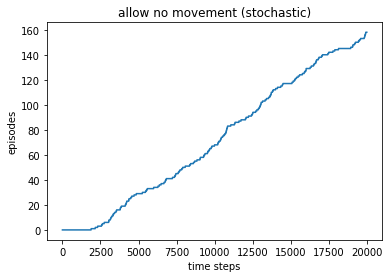

In [11]:
plt.plot(res)
plt.xlabel('time steps')
plt.ylabel('episodes')
plt.title('allow no movement (stochastic)')
plt.savefig('stochastic_no_movement_plot.png')

In [14]:
%%time
env = Environment(stochastic=True)
agent = TDAgent(env.get_states(), True)
res = train(env, agent, 20000)
trajectory = get_trajectory(env, agent)

[(3, 0), (2, 1), (0, 2), (1, 3), (4, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (5, 9), (5, 9), (5, 9), (4, 9), (4, 9), (3, 9), (1, 9), (1, 8), (1, 7), (1, 8), (3, 7)]
OOOOXXXXXX
OOOOOOOOOX
OOOXOOOOOX
XOOOOOOXOX
OXOOOOOOOO
OOOXOOOXXX
OOXOOOOOOO
CPU times: user 104 ms, sys: 3.96 ms, total: 108 ms
Wall time: 106 ms


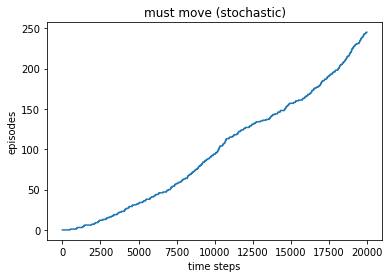

In [16]:
plt.plot(res)
plt.xlabel('time steps')
plt.ylabel('episodes')
plt.title('must move (stochastic)')
plt.savefig('stochastic_must_move_plot.png')